In [1]:
# Libraries

#for downloading data from NSE website
!pip install bhavcopy
import bhavcopy

#for several dataframe and other operations in python
import pandas as pd
from datetime import datetime, date
import os
import numpy as np
import math
import numpy as np
import io
import contextlib

#for calculating GARCH volatilities
!pip install arch
from arch import arch_model

#for calculating Black Scholes prices and Implied Volatility
from scipy.stats import norm
from scipy.optimize import newton
from scipy.optimize import fsolve

#for applying ANN, LSTM, GRU
import tensorflow as tf
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import GRU, Dense, Concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

#for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#for accessing google drive in google colab
from google.colab import drive
from google.colab import files

  Preparing metadata (setup.py) ... done
  Created wheel for bhavcopy: filename=bhavcopy-3.0-py3-none-any.whl size=5314 sha256=d69e81e122b83d9aeed8f135ad248e35f9677bc919c6e2c2fcc3ff31bf8965d2
  Stored in directory: /root/.cache/pip/wheels/98/6e/ec/d1ed7817d15c778faccd62848124dac5cb5d6acb28ef630f75
Successfully built bhavcopy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 3.2 MB/s eta 0:00:00


In [2]:
#function defined for calculating GARCH volatilties - same is accessed later in the code
#GARCH volatility has been further used as an input to Black Scholes model to find option prices

def garch_vol(returns, forecast_horizon, p, q):
    # Estimate GARCH(p,q) model for volatility
    with io.StringIO() as buf, contextlib.redirect_stdout(buf):
        garch_model = arch_model(returns, vol='Garch', p=p, q=q)
        results = garch_model.fit()

    # Forecast volatility
    forecast = results.forecast(horizon=forecast_horizon)
    vol = forecast.mean.iloc[-1]
    return vol

In [3]:
#function defined for calculating Black Scholes option prices - same is accessed later in the code

def BS(S, K, T, r, sigma, type):
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  if (type=='CE'):
    BS = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  elif (type=='PE'):
    BS = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
  return BS

#function defined for calculating implied volatilites - same is accessed later in the code
#3 different functions have been defined using bissection, fsolve and newton raphson methods of numerical estimation - currently the code later is using fsolver

def iv_bisec(opt_price, S, K, T, r, type):
    tol = 1e-5
    low_vol = 0.001
    high_vol = 5.0
    iterations = 100
    for i in range(iterations):
        mid_vol = (low_vol + high_vol) / 2.0
        price = BS(S, K, T, r, mid_vol, type)
        diff = price - opt_price
        if abs(diff) < tol:
            return mid_vol
        if diff < 0:
            low_vol = mid_vol
        else:
            high_vol = mid_vol
    return None  # Return None if no convergence

def iv_fsolve(opt_price, S, K, T, r, type):
  # Define the function to solve for implied volatility
    def function(sigma, *args):
        opt_price, S, K, T, r, type = args
        return BS(S, K, T, r, sigma, type) - opt_price

    # Initial guess for implied volatility
    initial_guess = 0.3  # You can start with any value here

    # Solve for implied volatility
    implied_vol = fsolve(function, initial_guess, args=(opt_price,S, K, T, r, type))

    return implied_vol[0]

def iv_newton(opt_price, S, K, T, r, type):
  # Define the function to solve for implied volatility
    def function(sigma):
        return BS(S, K, T, r, sigma, type) - opt_price

    # Initial guess for implied volatility
    initial_guess = 0.3  # You can start with any value here

    # Solve for implied volatility
    implied_vol = newton(function, initial_guess)

    return implied_vol

In [4]:
#Getting underlying equity index (NIFTY 50 data) for 2023 using API bhavcopy which fetches historical data from www.nseindia.com

# Mount Google Drive to save data
drive.mount('/content/drive')

# Define start and end dates, and convert them into date format
start_date = date(2023, 1, 1)
end_date = date(2023, 12, 31)

# Define wait time in seconds to avoid multiple fast hits on www.nseindia.com
wait_time = [1, 2]

# path of the folder in google drive where all input and output files and plots are getting stored.
folder_path = '/content/drive/My Drive/Capstone_Grp4524/'

# Check if the folder already exists; if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully!")
else:
    print(f"Folder '{folder_path}' already exists.")

try:
    # Attempt to load the file
    data_nifty = pd.read_csv('/content/drive/My Drive/Capstone_Grp4524/indices.csv', parse_dates=['TIMESTAMP'])
except FileNotFoundError:

# Instantiate bhavcopy class for equities, indices, and derivatives
    nse = bhavcopy.bhavcopy("indices", start_date, end_date, folder_path, wait_time)
    nse.get_data()
    if os.path.exists(os.path.join(folder_path, "\\indices.csv")):
    # Rename the file to "indices.csv"
      os.rename(os.path.join(folder_path, "\\indices.csv"), os.path.join(folder_path, "indices.csv"))
    data_nifty = pd.read_csv('/content/drive/My Drive/Capstone_Grp4524/indices.csv', parse_dates=['TIMESTAMP'])

data_nifty = data_nifty.loc[data_nifty['Index Name'] == 'Nifty 50']
data_nifty.rename(columns={"Index Name": "Index", "Closing Index Value": "Close"}, inplace=True)

#creating input columns using the underlying data - returns, squared returns, historical volatilies with different tenors
data_nifty['rt'] = pd.to_numeric(data_nifty['Change(%)'])
data_nifty['rt2'] = pd.to_numeric(data_nifty['rt'])**2.
data_nifty['sigma2'] = data_nifty['rt'].rolling(2).std()*(252**0.5)
data_nifty['sigma3'] = data_nifty['rt'].rolling(3).std()*(252**0.5)
data_nifty['sigma5'] = data_nifty['rt'].rolling(5).std()*(252**0.5)
data_nifty['sigma20'] = data_nifty['rt'].rolling(20).std()*(252**0.5)
data_nifty['sigma60'] = data_nifty['rt'].rolling(60).std()*(252**0.5)
data_nifty['sigma110'] = data_nifty['rt'].rolling(110).std()*(252**0.5)

#saving the processed underlying data file in folder
data_nifty.to_csv('/content/drive/My Drive/Capstone_Grp4524/data_nifty.csv')


Mounted at /content/drive
Folder '/content/drive/My Drive/Capstone_Grp4524/' created successfully!
Running File Check
The file does not exist. Creating File
2023-01-02 00:00:00
2023-01-02 00:00:00:done
2023-01-03 00:00:00
2023-01-03 00:00:00:done
2023-01-04 00:00:00
2023-01-04 00:00:00:done
2023-01-05 00:00:00
2023-01-05 00:00:00:done
2023-01-06 00:00:00
2023-01-06 00:00:00:done
2023-01-09 00:00:00
2023-01-09 00:00:00:done
2023-01-10 00:00:00
2023-01-10 00:00:00:done
2023-01-11 00:00:00
2023-01-11 00:00:00:done
2023-01-12 00:00:00
2023-01-12 00:00:00:done
2023-01-13 00:00:00
2023-01-13 00:00:00:done
2023-01-16 00:00:00
2023-01-16 00:00:00:done
2023-01-17 00:00:00
2023-01-17 00:00:00:done
2023-01-18 00:00:00
2023-01-18 00:00:00:done
2023-01-19 00:00:00
2023-01-19 00:00:00:done
2023-01-20 00:00:00
2023-01-20 00:00:00:done
2023-01-23 00:00:00
2023-01-23 00:00:00:done
2023-01-24 00:00:00
2023-01-24 00:00:00:done
2023-01-25 00:00:00
2023-01-25 00:00:00:done
HTTP Error: 404 Client Error: Not

In [5]:
#Getting option chain data on NIFTY 50 data fetching historical data (option chain for each day in 2023) from www.nseindia.com

dt = pd.date_range(start=start_date, end=end_date, freq='B')
datafno = pd.DataFrame()
try:
    # Attempt to load the file
    datafno = pd.read_csv('/content/drive/My Drive/Capstone_Grp4524/datafno.csv', parse_dates=['TIMESTAMP'])
    print("File found and loaded successfully!")
except FileNotFoundError:
    for tday in dt:
        try:
            dd = datetime.strftime(tday, '%d')
            MM = datetime.strftime(tday, '%b').upper()
            YYYY = datetime.strftime(tday, '%Y')
            fnoBhavcopyUrl = 'http://archives.nseindia.com/content/historical/DERIVATIVES/' +YYYY+ '/' +MM+ '/fo' + dd+ MM+ YYYY+'bhav.csv.zip'
            print(fnoBhavcopyUrl)
            datafno1 = pd.read_csv(fnoBhavcopyUrl, parse_dates=['EXPIRY_DT', 'TIMESTAMP'])
            datafno = pd.concat([datafno, datafno1], join = 'outer', ignore_index=True)
        except:
            print("Error in" + dd + MM + YYYY)

    datafno = datafno.drop(datafno.columns[15:], axis=1)
    datafno.columns = [c.strip() for c in datafno.columns.values.tolist()]

    #only taking FnO data on underlying index and dropping other indices and stocks to make file of manageable size
    datafno = datafno.loc[datafno['SYMBOL'] == 'NIFTY']

    #saving the processed Nifty50 FnO data file in folder
    datafno.to_csv('/content/drive/My Drive/Capstone_Grp4524/datafno.csv')

def check_date_format(date_string, date_format):
    try:
        datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False
    except TypeError:
        return False

def convert_date_format(date_string):
    if check_date_format(date_string, "%d-%b-%Y") == True:
        return datetime.strptime(date_string, "%d-%b-%Y").strftime('%d-%m-%Y')
    else:
        return date_string

datafno['EXPIRY_DT'] = pd.to_datetime(datafno['EXPIRY_DT'].apply(convert_date_format), dayfirst=True)

#separating out the FnO data into 2 files - one with futures and other with options
datafno_fut = datafno.loc[datafno['INSTRUMENT'] == 'FUTIDX']
datafno_opt = datafno.loc[(datafno['INSTRUMENT'] == 'OPTIDX')&(datafno['CONTRACTS'] > 0)]

http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo02JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo03JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo04JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo05JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo06JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo09JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo10JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo11JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo12JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/fo13JAN2023bhav.csv.zip
http://archives.nseindia.com/content/historical/DERIVATIVES/2023/JAN/f

In [6]:
#Creating input file for applying Black Scholes, GARCH volatilites, neural networks (ANN, LSTM, GRU)

data_input = pd.merge(datafno_opt, data_nifty, on='TIMESTAMP')
data_input['S'] = data_input['Close']
data_input['K'] = data_input['STRIKE_PR']
data_input['Moneyness'] = data_input['Close']/data_input['STRIKE_PR']
data_input['T'] = pd.to_datetime(data_input['EXPIRY_DT'])-pd.to_datetime(data_input['TIMESTAMP'])
data_input['T'] = data_input['T'].dt.days
r = 6.9441 #risk free 30day t-bill rate as taken from Reserve Bank of India website

#implied vol calculation using iv_fsolve function
data_input['IV'] = list(map(lambda opt_price, S, K, T, type: iv_fsolve(opt_price, S, K, T, r/100,type), data_input['CLOSE'], data_input['S'], data_input['K'], data_input['T']/365, data_input['OPTION_TYP']))
data_input = data_input.dropna()

#saving the processed input data file in folder
data_input.to_csv('/content/drive/My Drive/Capstone_Grp4524/data_input.csv')

#separating the input data into call options and put options
#we have used call options data only for the purpose of this study
data_inputCE = data_input.loc[data_input['OPTION_TYP'] == 'CE']
data_inputPE = data_input.loc[data_input['OPTION_TYP'] == 'PE']

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-3-79564a4429c2>:4: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [7]:
#forecasting volatilities using GARCH(1,1)

#data taken till 30th Sep 2023 as input in order to forecast volatility upto 63 days ahead till end Dec 2023
filtered_df = data_nifty[(data_nifty['TIMESTAMP'] <= pd.to_datetime(date(2023, 9, 30)))]

#forecasting for upto 63 trading days (3 calender month) to cover the entire year till end of 2023
forecast_horizons = range(1, 63)
forecast_results = {}
filtered_df['Close'] = pd.to_numeric(filtered_df['Close'], errors='coerce')
filtered_df.dropna(subset=['Close'], inplace=True)
garchvol = pd.DataFrame()
garchvol['T'] = forecast_horizons

for horizon in forecast_horizons:
    # Create a new column for returns with the specified horizon
    returns = filtered_df['Close'].pct_change(periods=horizon)
    filtered_df[f'Return_{horizon}D'] = returns
    rescaled_returns = returns[~np.isnan(returns)] * 100
    forecast_results[horizon] = garch_vol(rescaled_returns, horizon, 1, 1)

#filtered_df.to_csv('/content/drive/My Drive/Capstone_Grp4524/filtered_df.csv')

for horizon, volatility in forecast_results.items():
    print(f"Forecast horizon: {horizon}, Forecasted volatility: {volatility[0]*((252/horizon)**0.5):.4f}")
    garchvol.loc[(garchvol['T'] == horizon),'vol_garch'] = volatility[0]*((252/horizon)**0.5)

#saving the garchvol file in folder
garchvol.to_csv('/content/drive/My Drive/Capstone_Grp4524/garchvol.csv')


<ipython-input-7-2dad16f6b0b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Close'] = pd.to_numeric(filtered_df['Close'], errors='coerce')
<ipython-input-7-2dad16f6b0b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(subset=['Close'], inplace=True)
<ipython-input-7-2dad16f6b0b0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Forecast horizon: 1, Forecasted volatility: 0.8325
Forecast horizon: 2, Forecasted volatility: 1.4707
Forecast horizon: 3, Forecasted volatility: 1.6403
Forecast horizon: 4, Forecasted volatility: 2.2983
Forecast horizon: 5, Forecasted volatility: 1.4884
Forecast horizon: 6, Forecasted volatility: 2.3636
Forecast horizon: 7, Forecasted volatility: 2.7377
Forecast horizon: 8, Forecasted volatility: 3.8467
Forecast horizon: 9, Forecasted volatility: 4.6214
Forecast horizon: 10, Forecasted volatility: 3.9850
Forecast horizon: 11, Forecasted volatility: 5.0275
Forecast horizon: 12, Forecasted volatility: 4.6150
Forecast horizon: 13, Forecasted volatility: 5.4708
Forecast horizon: 14, Forecasted volatility: 5.7067
Forecast horizon: 15, Forecasted volatility: 5.9593
Forecast horizon: 16, Forecasted volatility: 6.1974
Forecast horizon: 17, Forecasted volatility: 7.8306
Forecast horizon: 18, Forecasted volatility: 6.6829
Forecast horizon: 19, Forecasted volatility: 7.8694
Forecast horizon: 20,

In [8]:
#calculation of option prices using Black Scholes

output_BS = pd.DataFrame()
columns_to_replicate = data_inputCE.iloc[:, 2:6]
output_BS[columns_to_replicate.columns] = columns_to_replicate
output_BS['Close'] = pd.to_numeric(data_inputCE['CLOSE'])
output_BS['q'] = pd.to_numeric(data_inputCE['Div Yield'])
output_BS['S'] = pd.to_numeric(data_inputCE['S'])
output_BS['K'] = pd.to_numeric(data_inputCE['K'])
output_BS['T'] = pd.to_numeric(data_inputCE['T'])
output_BS['r-q'] = r - output_BS['q']
output_BS['Moneyness'] = pd.to_numeric(data_inputCE['Moneyness']).round(3)
output_BS = pd.merge(output_BS, garchvol, on='T')
output_BS['BS_price'] = output_BS.apply(lambda row: BS(row['S'], row['K'], row['T']/365, row['r-q']/100, row['vol_garch']/100, 'CE'), axis=1)

#saving the Black Scholes option prices output file in folder
output_BS.to_csv('/content/drive/My Drive/Capstone_Grp4524/output_BS.csv')

#error metrics for BS output vis-a-vis actual market prices of corresponding options
mae = metrics.mean_absolute_error(output_BS['Close'], output_BS['BS_price'])
mse = metrics.mean_squared_error(output_BS['Close'], output_BS['BS_price'])
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(output_BS['Close'], output_BS['BS_price'])
r2 = metrics.r2_score(output_BS['Close'], output_BS['BS_price'])

print("BS error metrics:")
print("MAE:", "%.2f" %mae)
print("MSE:", "%.2f" %mse)
print("RMSE:", "%.2f" %rmse)
print("MAPE:", "%.2f" %mape)
print("R-Squared:", "%.3f" %r2)

BS error metrics:
MAE: 32.40
MSE: 2559.20
RMSE: 50.59
MAPE: 0.48
R-Squared: 0.996


Epoch 1/50
1241/1241 [==============================] - 5s 3ms/step - loss: 94140.2656 - mse: 94140.2656
Epoch 2/50
1241/1241 [==============================] - 5s 4ms/step - loss: 7556.0332 - mse: 7556.0332
Epoch 3/50
1241/1241 [==============================] - 3s 3ms/step - loss: 6127.0562 - mse: 6127.0562
Epoch 4/50
1241/1241 [==============================] - 3s 3ms/step - loss: 5293.2666 - mse: 5293.2666
Epoch 5/50
1241/1241 [==============================] - 3s 3ms/step - loss: 4877.8413 - mse: 4877.8413
Epoch 6/50
1241/1241 [==============================] - 4s 4ms/step - loss: 4558.2515 - mse: 4558.2515
Epoch 7/50
1241/1241 [==============================] - 4s 3ms/step - loss: 4407.8501 - mse: 4407.8501
Epoch 8/50
1241/1241 [==============================] - 3s 2ms/step - loss: 3987.5369 - mse: 3987.5369
Epoch 9/50
1241/1241 [==============================] - 3s 2ms/step - loss: 3658.0020 - mse: 3658.0020
Epoch 10/50
1241/1241 [==============================] - 3s 2ms/step - 

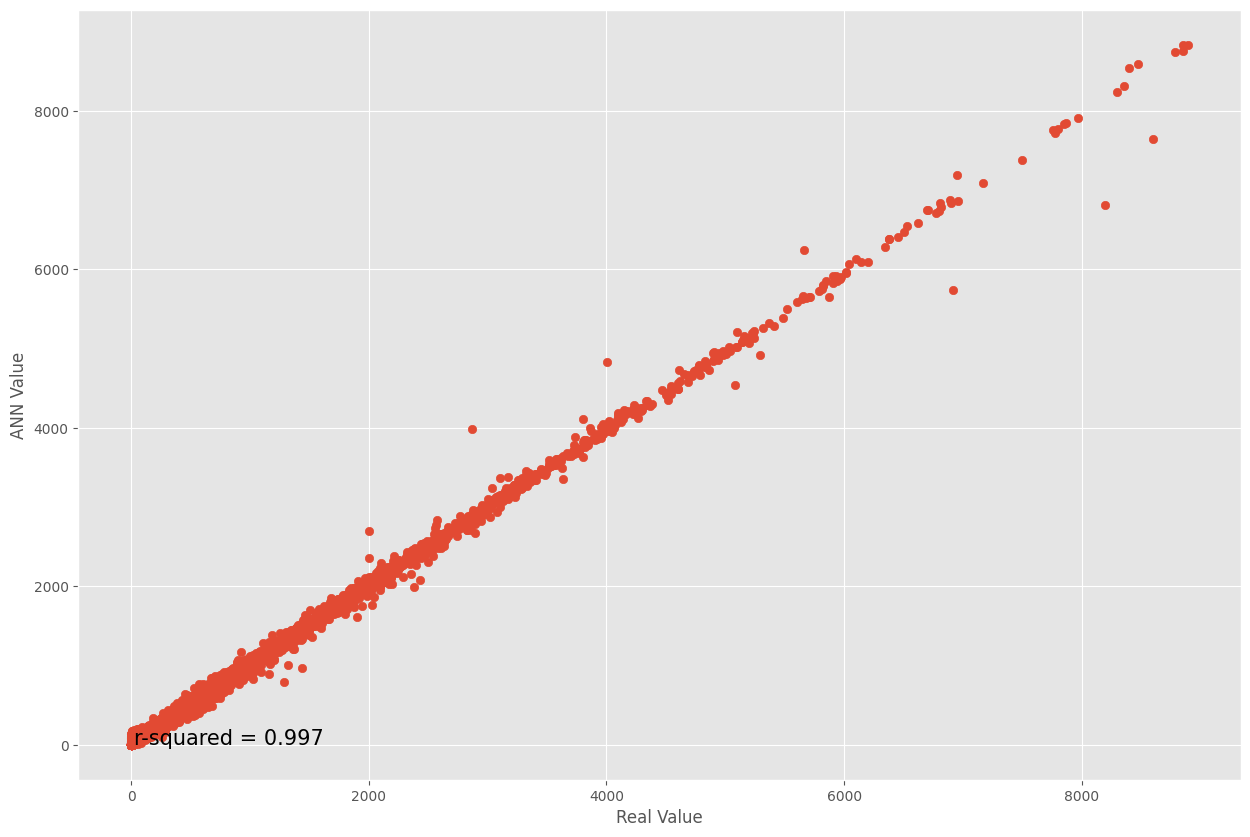

In [9]:
#Running ANN for call options

#number of input columns are last 14 columns of data_inputCE file
ncol = 14
X = data_inputCE.iloc[:,-ncol:]
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(data_inputCE['CLOSE'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create the neural network model
ANN = Sequential()
ANN.add(Dense(64, input_dim=ncol, activation='relu'))  # Input layer
ANN.add(Dense(32, activation='relu'))  # Hidden layer
ANN.add(Dense(32, activation='relu'))  # Hidden layer
ANN.add(Dense(32, activation='relu'))  # Hidden layer
ANN.add(Dense(1, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))  # Output layer

def custom_loss(y_true, y_pred):
    # Compute the mean squared error loss
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # Penalize negative predictions by adding their absolute values
    neg_penalty = tf.reduce_mean(tf.abs(tf.minimum(y_pred - y_true, 0)))
    # Total loss with an added penalty for negative predictions
    total_loss = mse_loss + neg_penalty
    return total_loss

# Compile the model
ANN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Train the model
ANN.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the test set
loss, mae = ANN.evaluate(X_test, y_test)

# Predict option prices using the trained model
y_pred = ANN.predict(X_test)
output_ANN = pd.DataFrame()
output_ANN['S'] = X_test['S']
output_ANN['K'] = X_test['K']
output_ANN['T'] = X_test['T']
#output_ANN['actual_price'] = y_test
output_ANN['ANN_price'] = y_pred.round(2)

#saving the ANN output to folder
output_ANN.to_csv('/content/drive/My Drive/Capstone_Grp4524/output_ANN.csv')

#preparing dataframe having comparison of actual prices, BS prices, ANN prices
comparemodels = pd.merge(output_BS, output_ANN, on=['S','K','T'])

#error metrics for ANN output vis-a-vis actual market prices of corresponding options
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("ANN error metrics:")
print("MAE:", "%.2f" %mae)
print("MSE:", "%.2f" %mse)
print("RMSE:", "%.2f" %rmse)
print("MAPE:", "%.2f" %mape)
print("R-Squared:", "%.3f" %r2)

#plotting ANN prices vs. actual prices
plt.figure(figsize=(15,10))
plt.scatter(y_test,y_pred)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test,y_pred)), (20,1), size=15)
plt.savefig('/content/drive/My Drive/Capstone_Grp4524/plot_ANN.png', format="png")
plt.show()

Epoch 1/30
1241/1241 [==============================] - 32s 20ms/step - loss: 6.1344e-04 - mse: 6.1344e-04 - val_loss: 1.0114e-04 - val_mse: 1.0114e-04
Epoch 2/30
1241/1241 [==============================] - 27s 22ms/step - loss: 1.0730e-04 - mse: 1.0730e-04 - val_loss: 4.4139e-05 - val_mse: 4.4139e-05
Epoch 3/30
1241/1241 [==============================] - 23s 18ms/step - loss: 8.1970e-05 - mse: 8.1970e-05 - val_loss: 3.3330e-05 - val_mse: 3.3330e-05
Epoch 4/30
1241/1241 [==============================] - 25s 20ms/step - loss: 7.8934e-05 - mse: 7.8934e-05 - val_loss: 4.6074e-05 - val_mse: 4.6074e-05
Epoch 5/30
1241/1241 [==============================] - 23s 19ms/step - loss: 7.3462e-05 - mse: 7.3462e-05 - val_loss: 3.8761e-05 - val_mse: 3.8761e-05
Epoch 6/30
1241/1241 [==============================] - 26s 21ms/step - loss: 6.6005e-05 - mse: 6.6005e-05 - val_loss: 3.0423e-05 - val_mse: 3.0423e-05
Epoch 7/30
1241/1241 [==============================] - 23s 19ms/step - loss: 5.9771e-05

<ipython-input-10-5fcdcdae597f>:57: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  comparemodels = pd.merge(comparemodels, output_LSTM, on=['S','K','T'])


LSTM error metrics:
MAE: 32.70
MSE: 3687.77
RMSE: 60.73
MAPE: 3.14
R-Squared: 0.996


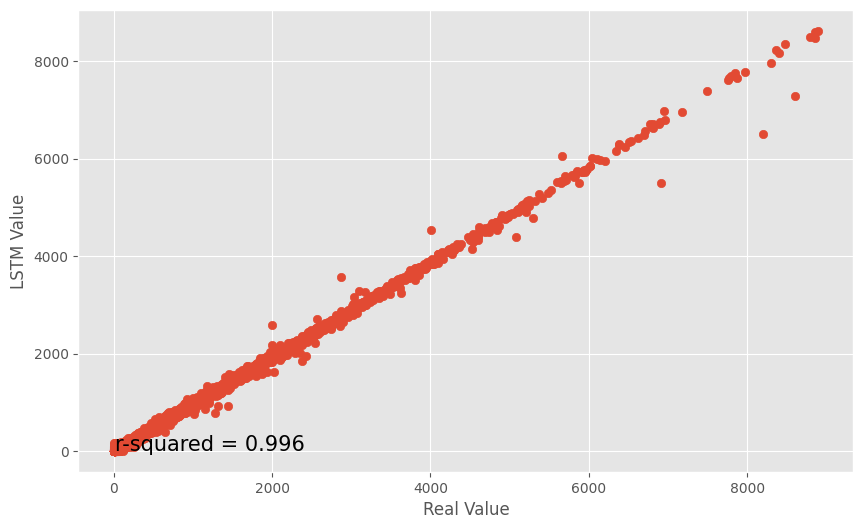

In [10]:
#Running LSTM for call options
# Assuming data and ncol are defined similarly to the previous code
# Preprocessing
data = data_inputCE.iloc[:,-ncol:]
data = data.apply(pd.to_numeric, errors='coerce')
data['opt_price'] = pd.to_numeric(data_inputCE['CLOSE'])
# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Splitting data into features and target
X = scaled_data[:, :-1]  # Features (all columns except the last one)
y = scaled_data[:, -1]   # Target (last column - option_price)
X = X.reshape(X.shape[0], 1, X.shape[1])
# Reshaping the data for LSTM (samples, time steps, features)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=200))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, kernel_constraint=tf.keras.constraints.NonNeg()))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Predictions
predicted_values = model.predict(X_test)

# You can inverse_transform the predicted values to get the actual option prices if needed
predicted_values = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), predicted_values), axis=1))
actual_prices = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), y_test.reshape(len(y_test), 1)), axis=1))
actual_prices = pd.DataFrame(actual_prices)
predicted_values = pd.DataFrame(predicted_values)
actual_prices.columns = data.columns
predicted_values.columns = data.columns
y_test = actual_prices.iloc[:,-1:]
y_pred = predicted_values.iloc[:,-1:]
output_LSTM = pd.DataFrame()
output_LSTM['S'] = actual_prices['S']
output_LSTM['K'] = actual_prices['K']
output_LSTM['T'] = actual_prices['T']
output_LSTM['LSTM_price'] = y_pred.round(2)

#saving the LSTM output to folder
output_LSTM.to_csv('/content/drive/My Drive/Capstone_Grp4524/output_LSTM.csv')

#comparison of actual prices, BS prices, ANN prices, LSTM prices
comparemodels = pd.merge(comparemodels, output_LSTM, on=['S','K','T'])

#error metrics for LSTM output vis-a-vis actual market prices of corresponding options
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("LSTM error metrics:")
print("MAE:", "%.2f" %mae)
print("MSE:", "%.2f" %mse)
print("RMSE:", "%.2f" %rmse)
print("MAPE:", "%.2f" %mape)
print("R-Squared:", "%.3f" %r2)

#plotting LSTM prices vs. actual prices
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred)
plt.xlabel("Real Value")
plt.ylabel("LSTM Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test,y_pred)), (20,1), size=15)
plt.savefig('/content/drive/My Drive/Capstone_Grp4524/plot_LSTM.png', format="png")
plt.show()

Epoch 1/30
1241/1241 [==============================] - 30s 20ms/step - loss: 5.2503e-04 - mse: 5.2503e-04 - val_loss: 5.2289e-05 - val_mse: 5.2289e-05
Epoch 2/30
1241/1241 [==============================] - 24s 19ms/step - loss: 1.2964e-04 - mse: 1.2964e-04 - val_loss: 4.8683e-05 - val_mse: 4.8683e-05
Epoch 3/30
1241/1241 [==============================] - 23s 19ms/step - loss: 1.0898e-04 - mse: 1.0898e-04 - val_loss: 3.0718e-05 - val_mse: 3.0718e-05
Epoch 4/30
1241/1241 [==============================] - 25s 20ms/step - loss: 9.0422e-05 - mse: 9.0422e-05 - val_loss: 2.8683e-05 - val_mse: 2.8683e-05
Epoch 5/30
1241/1241 [==============================] - 23s 18ms/step - loss: 7.7664e-05 - mse: 7.7664e-05 - val_loss: 4.9625e-05 - val_mse: 4.9625e-05
Epoch 6/30
1241/1241 [==============================] - 25s 20ms/step - loss: 7.9242e-05 - mse: 7.9242e-05 - val_loss: 3.0336e-05 - val_mse: 3.0336e-05
Epoch 7/30
1241/1241 [==============================] - 22s 18ms/step - loss: 7.7148e-05

<ipython-input-11-66e7567e7041>:53: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  comparemodels = pd.merge(comparemodels, output_GRU, on=['S','K','T'])


GRU error metrics:
MAE: 39.11
MSE: 3727.55
RMSE: 61.05
MAPE: 3.10
R-Squared: 0.996


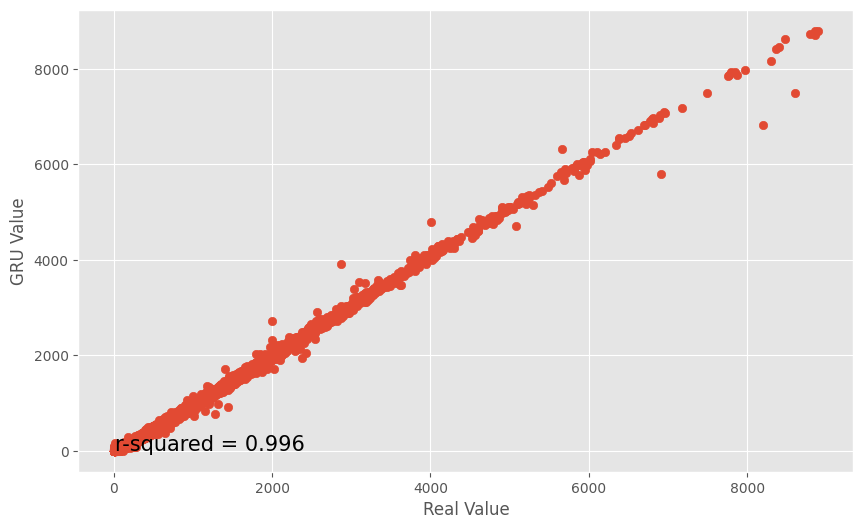

In [11]:
#Running GRU for call options
# Assuming data and ncol are defined similarly to the previous code
# Preprocessing
data = data_inputCE.iloc[:, -ncol:]
data = data.apply(pd.to_numeric, errors='coerce')
data['opt_price'] = pd.to_numeric(data_inputCE['CLOSE'])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

X = scaled_data[:, :-1]
y = scaled_data[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential()
model.add(GRU(units=200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=200))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, kernel_constraint=tf.keras.constraints.NonNeg()))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Predictions
predicted_values = model.predict(X_test)

# Inverse transform for original scale
predicted_values = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), predicted_values), axis=1))
actual_prices = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), y_test.reshape(len(y_test), 1)), axis=1))
actual_prices = pd.DataFrame(actual_prices)
predicted_values = pd.DataFrame(predicted_values)
actual_prices.columns = data.columns
predicted_values.columns = data.columns
y_test = actual_prices.iloc[:, -1:]
y_pred = predicted_values.iloc[:, -1:]
output_GRU = pd.DataFrame()
output_GRU['S'] = actual_prices['S']
output_GRU['K'] = actual_prices['K']
output_GRU['T'] = actual_prices['T']
output_GRU['GRU_price'] = y_pred.round(2)

#saving the GRU output to folder
output_GRU.to_csv('/content/drive/My Drive/Capstone_Grp4524/output_GRU.csv')
comparemodels = pd.merge(comparemodels, output_GRU, on=['S','K','T'])

#saving the final comparison of option prices from all models
comparemodels.to_csv('/content/drive/My Drive/Capstone_Grp4524/comparemodels.csv')

#error metrics for GRU output vis-a-vis actual market prices of corresponding options
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("GRU error metrics:")
print("MAE:", "%.2f" %mae)
print("MSE:", "%.2f" %mse)
print("RMSE:", "%.2f" %rmse)
print("MAPE:", "%.2f" %mape)
print("R-Squared:", "%.3f" %r2)

#plotting GRU prices vs. actual prices
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.xlabel("Real Value")
plt.ylabel("GRU Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (20,1), size=15)
plt.savefig('/content/drive/My Drive/Capstone_Grp4524/plot_GRU.png', format="png")
plt.show()